# Animals Classification
Yoga Mileniandi

### Load the library

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from zipfile import ZipFile
from PIL import Image

### Get data From Kaggle

In [ ]:
# Set Kaggle API Permission
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Get Dataset From Kaggle
!kaggle datasets download -d alessiocorrado99/animals10

 97% 569M/586M [00:11<00:00, 53.9MB/s]
100% 586M/586M [00:11<00:00, 51.7MB/s]


In [ ]:
path = 'animals10.zip'
with ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('working')

In [ ]:
path = 'working/raw-img'
os.listdir(path)

['elefante',
 'gatto',
 'gallina',
 'pecora',
 'cavallo',
 'ragno',
 'farfalla',
 'scoiattolo',
 'mucca',
 'cane']

### Preprocessing

In [ ]:
# Rename directories
categories = {'cane': 'dog', "cavallo": "horse", "elefante": "elephant", 
              "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
              "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel","ragno":"spider"}
for origin,translate in categories.items():
  os.rename(os.path.join(path, origin), os.path.join(path, translate))


In [ ]:
# Check
for animal in os.listdir(path):
  print(f"{animal} : {len(os.listdir(os.path.join(path, animal)))}")

horse : 2623
squirrel : 1862
cow : 1866
elephant : 1446
cat : 1668
dog : 4863
chicken : 3098
spider : 4821
butterfly : 2112
sheep : 1820


In [ ]:
# Create Train and Validation Directory
TRAIN_DIR = 'working/train'
VAL_DIR = 'working/val'

os.mkdir(TRAIN_DIR)
os.mkdir(VAL_DIR)

In [ ]:
# create directory 
dir_name = ['horse', 'chicken', 'spider']
for dir in dir_name:
  os.mkdir(os.path.join(TRAIN_DIR, dir))
  os.mkdir(os.path.join(VAL_DIR, dir))


In [ ]:
# Select horse, chicken and spider
# So the total dataset is 10542
for dir in dir_name:
  dir_file = os.path.join(path, dir)
  train = os.path.join(TRAIN_DIR, dir)
  val = os.path.join(VAL_DIR, dir)

  train_split, val_split = train_test_split(os.listdir(dir_file), test_size = 0.2)
  for filename in train_split:
    shutil.copy(os.path.join(dir_file, filename), os.path.join(train, filename))
  for filename in val_split:
    shutil.copy(os.path.join(dir_file, filename), os.path.join(val, filename))

In [ ]:
for dir in dir_name:
  for i in [TRAIN_DIR, VAL_DIR]:
    current_dir = os.path.join(i, dir)
    print(current_dir)
    print(f"Number of Files : {len([file for file in os.listdir(current_dir)])}")

working/train/horse
Number of Files : 2098
working/val/horse
Number of Files : 525
working/train/chicken
Number of Files : 2478
working/val/chicken
Number of Files : 620
working/train/spider
Number of Files : 3856
working/val/spider
Number of Files : 965


In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest'
)

val_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = 32,
    class_mode = 'categorical'
)

val_generator = train_datagen.flow_from_directory(
    VAL_DIR,
    target_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 8432 images belonging to 3 classes.
Found 2110 images belonging to 3 classes.


### Modelling

In [ ]:
model = Sequential()

model.add(Conv2D(64,(3,3), activation = 'relu', input_shape = (IMG_HEIGHT,IMG_WIDTH,3)))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 128)      

In [ ]:
class CallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.92 and logs.get('accuracy') > 0.92:
            self.model.stop_training = True
            print('Akurasi telah mencapai 92%')
            
callback = CallBack()

In [ ]:
hist =model.fit(
        train_generator,
        steps_per_epoch=8432/32,  
        epochs=77, 
        validation_data=val_generator, 
        validation_steps=2110/32,  
        verbose=1,
        callbacks = [callback])

Epoch 1/77
263/263 [==============================] - 311s 1s/step - loss: 0.8354 - accuracy: 0.6180 - val_loss: 0.5866 - val_accuracy: 0.7592
Epoch 2/77
263/263 [==============================] - 310s 1s/step - loss: 0.5298 - accuracy: 0.7896 - val_loss: 0.4248 - val_accuracy: 0.8270
Epoch 3/77
263/263 [==============================] - 309s 1s/step - loss: 0.4371 - accuracy: 0.8290 - val_loss: 0.3421 - val_accuracy: 0.8758
Epoch 4/77
263/263 [==============================] - 309s 1s/step - loss: 0.3798 - accuracy: 0.8590 - val_loss: 0.3832 - val_accuracy: 0.8578
Epoch 5/77
263/263 [==============================] - 308s 1s/step - loss: 0.3373 - accuracy: 0.8690 - val_loss: 0.3160 - val_accuracy: 0.8796
Epoch 6/77
263/263 [==============================] - 307s 1s/step - loss: 0.2859 - accuracy: 0.8921 - val_loss: 0.2864 - val_accuracy: 0.8981
Epoch 7/77
263/263 [==============================] - 307s 1s/step - loss: 0.2754 - accuracy: 0.8998 - val_loss: 0.2471 - val_accuracy: 0.9090

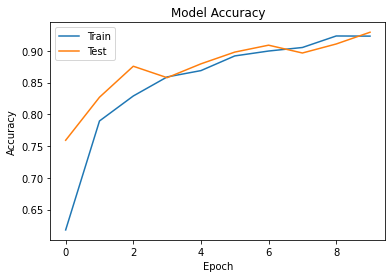

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])

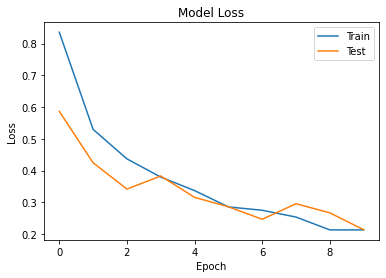

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])

### Save to TFLite format

In [ ]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpui_otuwg/assets


In [ ]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)